In [1]:
import numpy as np
import pandas as pd
import pickle
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import load_model
from sklearn.metrics import accuracy_score, classification_report

In [2]:
# 1. Load test data
df = pd.read_csv('../../data/raw/IMDB Dataset.csv')

In [3]:
# 2. Clean text (reuse your clean_text function)
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

def clean_text(text):
    text = re.sub(r'<[^>]+>', '', text)
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    text = text.lower()
    stop_words = set(stopwords.words('english'))
    lemmatizer = WordNetLemmatizer()
    words = text.split()
    words = [lemmatizer.lemmatize(word) for word in words if word not in stop_words]
    return ' '.join(words)

df['cleaned_review'] = df['review'].apply(clean_text)
df['sentiment_label'] = df['sentiment'].apply(lambda x: 1 if x == 'positive' else 0)

In [4]:
# 3. Split to get test set (same as training split)
from sklearn.model_selection import train_test_split
train_df, temp_df = train_test_split(df, test_size=0.3, random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42)

In [5]:
# 4. Load tokenizer
with open('tokenizer.pkl', 'rb') as f:
    tokenizer = pickle.load(f)

In [6]:
# 5. Convert test data to sequences and pad
max_length = 200
def texts_to_sequences_capped(tokenizer, texts):
    seq = tokenizer.texts_to_sequences(texts)
    return [[min(i, tokenizer.num_words - 1) for i in s] for s in seq]

test_sequences = texts_to_sequences_capped(tokenizer, test_df['cleaned_review'])
test_padded = pad_sequences(test_sequences, maxlen=max_length, padding='post', truncating='post')

In [7]:
# 6. Load the best model
model = load_model('best_model.keras')


In [8]:
# 7. Predict
y_true = test_df['sentiment_label'].values
y_pred_prob = model.predict(test_padded)
y_pred = (y_pred_prob >= 0.5).astype(int).flatten()

# 8. Evaluate
print("Test Accuracy:", accuracy_score(y_true, y_pred))
print(classification_report(y_true, y_pred, target_names=['Negative', 'Positive']))

235/235 ━━━━━━━━━━━━━━━━━━━━ 9s 35ms/step
Test Accuracy: 0.8726666666666667
              precision    recall  f1-score   support

    Negative       0.89      0.85      0.87      3722
    Positive       0.86      0.89      0.88      3778

    accuracy                           0.87      7500
   macro avg       0.87      0.87      0.87      7500
weighted avg       0.87      0.87      0.87      7500



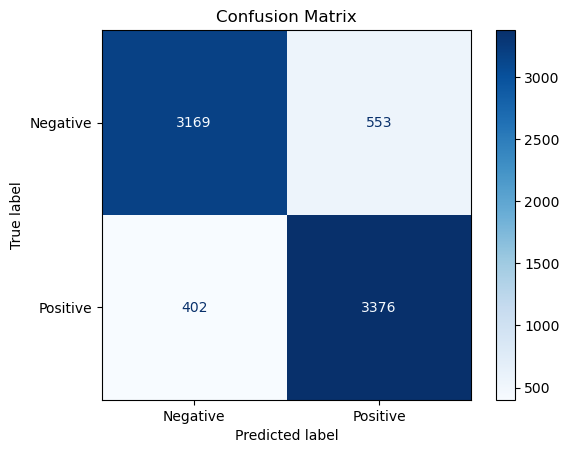

In [ ]:
# 8. Confusion Matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Negative', 'Positive'])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()